## __Parse data from wikipage to Dataframe__

In [1]:
#import lib
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
url = 'https://en.wikipedia.org/wiki/Districts_of_Prague'

In [3]:
data = requests.get(url).text

In [4]:
soup = BeautifulSoup(data, 'html.parser')
nieghborhood = []

In [5]:
my_table = soup.find('table',{'class':'wikitable'})

In [6]:
#we need to get the administrative districts
adm_distr = []
for tr in my_table.find_all('tr'):
    row_data=[]
    for a in tr.find_all('a'):
        row_data.append(a.text)
    if len(row_data)==0:
        continue
    else:
        adm_distr.append(row_data[0])

In [7]:
#make dataframe
distr_df = pd.DataFrame(adm_distr, columns=['Administrative district'])

In [8]:
distr_df = distr_df.drop_duplicates()

In [9]:
distr_df = distr_df.reset_index(drop=True)

In [10]:
#our list of administrative district in Prague
distr_df

,Administrative district
0,Prague 1
1,Prague 2
2,Prague 3
3,Prague 4
4,Prague 11
5,Prague 12
6,Prague 5
7,Prague 13
8,Prague 16
9,Prague 17


In [11]:
distr_df.shape

(22, 1)

## __Get the geographical coordinates__

In [12]:
import numpy as np # library to handle data in a vectorized manner
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import geocoder

print('Libraries imported.')

Libraries imported.


In [13]:
#coordinates of the center of Prague
address = 'prague, czech'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Prague are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Prague are 50.0864234, 14.4156772.


In [14]:
#get_coord each district
long = []
latit = []
for district in distr_df['Administrative district'].to_list():
    
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis('{}, Prague, Czech'.format(district))
      lat_lng_coords = g.latlng

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    latit.append(latitude)
    long.append(longitude)

In [15]:
#concatenate coordinates with original DF
distr_df['Latitude'] = pd.DataFrame(latit)
distr_df['Longitude'] = pd.DataFrame(long)

In [16]:
#show Prague district with coordinates
distr_df

,Administrative district,Latitude,Longitude
0,Prague 1,50.08728,14.41742
1,Prague 2,50.07394,14.43956
2,Prague 3,50.08260,14.45537
3,Prague 4,50.04232,14.44812
4,Prague 11,50.03094,14.52406
5,Prague 12,50.00201,14.41810
6,Prague 5,50.07167,14.40098
7,Prague 13,50.04925,14.33801
8,Prague 16,49.98318,14.36187
9,Prague 17,50.07297,14.30813


In [17]:
distr_df.shape

(22, 3)

## Prague district


<a href="https://en.wikipedia.org/wiki/Districts_of_Prague"><img src = "https://raw.githubusercontent.com/DMBabich/Coursera_Capstone/main/Final_Capstone/Prague_Subdivisions.png"></a>

## __Create a map of Prague with district__

In [18]:
# create map of Prague using latitude and longitude values
map_prague = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(distr_df['Latitude'], distr_df['Longitude'], distr_df['Administrative district']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_prague)  
    
map_prague

* map of Prague with district

![Prague district](https://raw.githubusercontent.com/DMBabich/Coursera_Capstone/main/Final_Capstone/map_coord_prague_dustrict.jpg "Prague district")

## __Utilizing the Foursquare API to explore the neighborhoods and segment them__

In [19]:
CLIENT_ID = '*****' # your Foursquare ID
CLIENT_SECRET = '*****' # your Foursquare Secret
VERSION = '20201010' # Foursquare API version 20180605
LIMIT = 100 # A default Foursquare API limit value
search_query = 'Gym'

In [20]:
#make a function to get data for each area
def getGym(names, latitudes, longitudes, radius=500):
    
    gym_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        gym_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_gym = pd.DataFrame([item for gym_list in gym_list for item in gym_list])
    nearby_gym.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'GYM', 
                  'GYM Latitude', 
                  'GYM Longitude', 
                  'Category']
    
    return(nearby_gym)

In [21]:
#make DF
prague_gym = getGym(names=distr_df['Administrative district'],
                                   latitudes=distr_df['Latitude'],
                                   longitudes=distr_df['Longitude']
                                  )

Prague 1
Prague 2
Prague 3
Prague 4
Prague 11
Prague 12
Prague 5
Prague 13
Prague 16
Prague 17
Prague 6
Prague 7
Prague 8
Prague 9
Prague 14
Prague 18
Prague 19
Prague 20
Prague 21
Prague 10
Prague 15
Prague 22


In [22]:
print(prague_gym.shape)
prague_gym.head()

(87, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,GYM,GYM Latitude,GYM Longitude,Category
0,Prague 1,50.08728,14.41742,Jan Kareš Fitness,50.088716,14.423769,Gym / Fitness Center
1,Prague 1,50.08728,14.41742,Gym at Four Seasons Hotel Prague,50.087694,14.414198,Gym
2,Prague 1,50.08728,14.41742,Posilovna Právnické fakulty UK,50.091199,14.417353,College Gym
3,Prague 1,50.08728,14.41742,Sport klub U Divadla,50.085571,14.423083,Gym
4,Prague 1,50.08728,14.41742,Fitness Týn,50.088765,14.423742,Gym / Fitness Center


In [23]:
#save our result
#prague_gym.to_csv('prague_gym.csv')

__Let's watch to popular name of gym:__

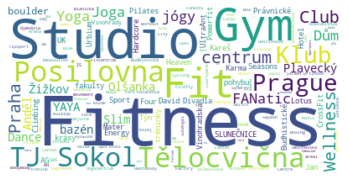

In [65]:
#Let's make a wordcloud from the gym names to find the popular name
import matplotlib.pyplot as plt
from wordcloud import WordCloud

gym_names = WordCloud(
    background_color='white',
).generate(prague_gym['GYM'].str.cat(sep=' '))

# display the word cloud
plt.imshow(gym_names, interpolation='bilinear')
plt.axis('off')
plt.show()

#save word cloud to png
#gym_names.to_file('gym_name_cloud.png')

* word cloud

![Word Cloud](https://raw.githubusercontent.com/DMBabich/Coursera_Capstone/main/Final_Capstone/gym_name_cloud.png "Word Cloud")

In [41]:
prague_gym.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,GYM,GYM Latitude,GYM Longitude,Category
Neighborhood,,,,,,
Prague 1,9,9,9,9,9,9
Prague 10,4,4,4,4,4,4
Prague 11,2,2,2,2,2,2
Prague 13,1,1,1,1,1,1
Prague 15,1,1,1,1,1,1
Prague 16,1,1,1,1,1,1
Prague 18,1,1,1,1,1,1
Prague 19,1,1,1,1,1,1
Prague 2,12,12,12,12,12,12


### Analyze each neighboorhod

In [42]:
# one hot encoding
prague_onehot = pd.get_dummies(prague_gym[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
prague_onehot['Neighborhood'] = prague_gym['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [prague_onehot.columns[-1]] + list(prague_onehot.columns[:-1])
prague_onehot = prague_onehot[fixed_columns]

prague_onehot.head()

,Neighborhood,Athletics & Sports,Boxing Gym,Climbing Gym,College Gym,Dance Studio,Gym,Gym / Fitness Center,Gym Pool,Martial Arts School,Medical Center,Pilates Studio,Spiritual Center,Yoga Studio
0,Prague 1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,Prague 1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Prague 1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Prague 1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Prague 1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [46]:
prague_onehot.shape

(87, 14)

Show unique category

In [24]:
prague_gym['Category'].unique()

array(['Gym / Fitness Center', 'Gym', 'College Gym', 'Yoga Studio',
       'Spiritual Center', 'Pilates Studio', 'Climbing Gym', 'Gym Pool',
       'Dance Studio', 'Boxing Gym', 'Martial Arts School',
       'Medical Center', 'Athletics & Sports'], dtype=object)

Remove extra columns that are not in the Gym / Fitness category

In [47]:
prague_onehot.drop(['Spiritual Center', 'Dance Studio', 'Medical Center', 'Athletics & Sports'], axis=1, inplace=True)

In [48]:
prague_onehot.head()

,Neighborhood,Boxing Gym,Climbing Gym,College Gym,Gym,Gym / Fitness Center,Gym Pool,Martial Arts School,Pilates Studio,Yoga Studio
0,Prague 1,0,0,0,0,1,0,0,0,0
1,Prague 1,0,0,0,1,0,0,0,0,0
2,Prague 1,0,0,1,0,0,0,0,0,0
3,Prague 1,0,0,0,1,0,0,0,0,0
4,Prague 1,0,0,0,0,1,0,0,0,0


__Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category__

In [49]:
prague_grouped = prague_onehot.groupby('Neighborhood').mean().reset_index()
prague_grouped

,Neighborhood,Boxing Gym,Climbing Gym,College Gym,Gym,Gym / Fitness Center,Gym Pool,Martial Arts School,Pilates Studio,Yoga Studio
0,Prague 1,0.0,0.111111,0.111111,0.222222,0.222222,0.000000,0.0,0.111111,0.111111
1,Prague 10,0.0,0.000000,0.000000,0.500000,0.250000,0.000000,0.0,0.000000,0.000000
2,Prague 11,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,Prague 13,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,Prague 15,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,Prague 16,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
6,Prague 18,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,Prague 19,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
8,Prague 2,0.0,0.000000,0.083333,0.166667,0.333333,0.000000,0.0,0.000000,0.416667
9,Prague 20,0.0,0.000000,0.500000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000


__Let's print each neighborhood along with the top 5 most common venues__

In [50]:
num_top_venues = 5

for hood in prague_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = prague_grouped[prague_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Prague 1----
                  venue  freq
0                   Gym  0.22
1  Gym / Fitness Center  0.22
2          Climbing Gym  0.11
3           College Gym  0.11
4        Pilates Studio  0.11


----Prague 10----
                  venue  freq
0                   Gym  0.50
1  Gym / Fitness Center  0.25
2            Boxing Gym  0.00
3          Climbing Gym  0.00
4           College Gym  0.00


----Prague 11----
                  venue  freq
0                   Gym   1.0
1            Boxing Gym   0.0
2          Climbing Gym   0.0
3           College Gym   0.0
4  Gym / Fitness Center   0.0


----Prague 13----
                  venue  freq
0                   Gym   1.0
1            Boxing Gym   0.0
2          Climbing Gym   0.0
3           College Gym   0.0
4  Gym / Fitness Center   0.0


----Prague 15----
                  venue  freq
0                   Gym   1.0
1            Boxing Gym   0.0
2          Climbing Gym   0.0
3           College Gym   0.0
4  Gym / Fitness Center   0.0


-

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

__Let's create a new dataframe that includes the cluster as well as the top 5 gym for each neighborhood.__

In [52]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = prague_grouped['Neighborhood']

for ind in np.arange(prague_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(prague_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Prague 1,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,College Gym
1,Prague 10,Gym,Gym / Fitness Center,Yoga Studio,Pilates Studio,Martial Arts School
2,Prague 11,Gym,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool
3,Prague 13,Gym,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool
4,Prague 15,Gym,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool


In [53]:
neighborhoods_venues_sorted.shape

(17, 6)

## __Clustering neighbornhood__

In [54]:
# set number of clusters
kclusters = 4

prague_grouped_clustering = prague_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(prague_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 0, 0, 3, 2, 3, 1, 2])

Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.


In [55]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

prague_merged = distr_df

# merge prague_grouped with prague data to add latitude/longitude for each neighborhood
prague_merged = prague_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Administrative district')

prague_merged.head() # check the last columns!

,Administrative district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Prague 1,50.08728,14.41742,1.0,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,College Gym
1,Prague 2,50.07394,14.43956,1.0,Yoga Studio,Gym / Fitness Center,Gym,College Gym,Pilates Studio
2,Prague 3,50.08260,14.45537,1.0,Gym / Fitness Center,Gym,Yoga Studio,Martial Arts School,Gym Pool
3,Prague 4,50.04232,14.44812,3.0,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,Martial Arts School
4,Prague 11,50.03094,14.52406,0.0,Gym,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool


__Let's see if there are areas where there is not enough gym__

In [56]:
prague_no_gym = prague_merged[prague_merged['1st Most Common Venue'].isnull()]

In [57]:
prague_no_gym

,Administrative district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Prague 12,50.00201,14.41810,NaN,NaN,NaN,NaN,NaN,NaN
9,Prague 17,50.07297,14.30813,NaN,NaN,NaN,NaN,NaN,NaN
14,Prague 14,50.10054,14.55486,NaN,NaN,NaN,NaN,NaN,NaN
18,Prague 21,50.07715,14.66000,NaN,NaN,NaN,NaN,NaN,NaN
21,Prague 22,50.03129,14.59919,NaN,NaN,NaN,NaN,NaN,NaN


__delete data where was Nan__

In [58]:
prague_merged = prague_merged.dropna()

Finally, let's visualize the resulting clusters


In [59]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(prague_merged['Latitude'], prague_merged['Longitude'], prague_merged['Administrative district'], prague_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

* map of clusters in Prague

![map clustering](https://raw.githubusercontent.com/DMBabich/Coursera_Capstone/main/Final_Capstone/map_clusters_prague.jpg "Clustering map")

In [60]:
prague_merged

,Administrative district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Prague 1,50.08728,14.41742,1.0,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,College Gym
1,Prague 2,50.07394,14.43956,1.0,Yoga Studio,Gym / Fitness Center,Gym,College Gym,Pilates Studio
2,Prague 3,50.08260,14.45537,1.0,Gym / Fitness Center,Gym,Yoga Studio,Martial Arts School,Gym Pool
3,Prague 4,50.04232,14.44812,3.0,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,Martial Arts School
4,Prague 11,50.03094,14.52406,0.0,Gym,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool
6,Prague 5,50.07167,14.40098,1.0,Gym / Fitness Center,Gym,College Gym,Yoga Studio,Pilates Studio
7,Prague 13,50.04925,14.33801,0.0,Gym,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool
8,Prague 16,49.98318,14.36187,3.0,Gym / Fitness Center,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool
10,Prague 6,50.10106,14.39981,1.0,Gym,Gym / Fitness Center,Yoga Studio,College Gym,Pilates Studio
11,Prague 7,50.10800,14.43797,1.0,Climbing Gym,Gym Pool,Gym / Fitness Center,Gym,College Gym


#### __Examine clustering__

In [61]:
prague_merged.loc[prague_merged['Cluster Labels'] == 0]

,Administrative district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,Prague 11,50.03094,14.52406,0.0,Gym,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool
7,Prague 13,50.04925,14.33801,0.0,Gym,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool
20,Prague 15,50.04703,14.55586,0.0,Gym,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool


In [62]:
prague_merged.loc[prague_merged['Cluster Labels'] == 1]

,Administrative district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Prague 1,50.08728,14.41742,1.0,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,College Gym
1,Prague 2,50.07394,14.43956,1.0,Yoga Studio,Gym / Fitness Center,Gym,College Gym,Pilates Studio
2,Prague 3,50.08260,14.45537,1.0,Gym / Fitness Center,Gym,Yoga Studio,Martial Arts School,Gym Pool
6,Prague 5,50.07167,14.40098,1.0,Gym / Fitness Center,Gym,College Gym,Yoga Studio,Pilates Studio
10,Prague 6,50.10106,14.39981,1.0,Gym,Gym / Fitness Center,Yoga Studio,College Gym,Pilates Studio
11,Prague 7,50.10800,14.43797,1.0,Climbing Gym,Gym Pool,Gym / Fitness Center,Gym,College Gym
12,Prague 8,50.12692,14.45672,1.0,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool,Gym / Fitness Center
13,Prague 9,50.11058,14.50034,1.0,Gym,Yoga Studio,Gym / Fitness Center,College Gym,Pilates Studio
19,Prague 10,50.06762,14.46016,1.0,Gym,Gym / Fitness Center,Yoga Studio,Pilates Studio,Martial Arts School


In [63]:
prague_merged.loc[prague_merged['Cluster Labels'] == 2]

,Administrative district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,Prague 18,50.15175,14.52394,2.0,College Gym,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool
17,Prague 20,50.11533,14.61252,2.0,Gym / Fitness Center,College Gym,Yoga Studio,Pilates Studio,Martial Arts School


In [64]:
prague_merged.loc[prague_merged['Cluster Labels'] == 3]

,Administrative district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Prague 4,50.04232,14.44812,3.0,Gym / Fitness Center,Gym,Yoga Studio,Pilates Studio,Martial Arts School
8,Prague 16,49.98318,14.36187,3.0,Gym / Fitness Center,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool
16,Prague 19,50.13372,14.54743,3.0,Gym / Fitness Center,Yoga Studio,Pilates Studio,Martial Arts School,Gym Pool
